In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler


import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/statistics-07-20.csv', sep = ';')

In [ ]:
# Чтобы увидеть все колонки
pd.set_option('display.max_columns', None)
# Отображать данные float с 1 знаком после запятой
pd.options.display.float_format ='{:,.0f}'.format


# Анализ данных

In [5]:
data.head()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,NaN,NaN,62827035,984700.0,NaN,NaN,NaN,2.0,81.0,2020-07-16 03:40:00,...,2.000039e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,62827035,862201.0,20.0,NaN,421034.0,NaN,18.0,2020-07-16 14:10:00,...,2.002026e+09,NaN,93149858.0,60.0,NaN,68398528.0,NaN,NaN,249.0,NaN
2,NaN,NaN,62827316,863007.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:50:00,...,2.001933e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,62827381,862108.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:16:00,...,2.001931e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,62845730,887904.0,20.0,NaN,421034.0,NaN,19.0,2020-07-16 15:15:00,...,2.000039e+09,NaN,81195103.0,60.0,NaN,52682351.0,NaN,NaN,248.0,NaN


In [6]:
data = data[(data['operation_car'].isna() == False) & (data['operation_st_esr'].isna() == False)].copy()

In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

In [8]:
def find_duplicates_by_columns(df):  # функция для поиска дубликатов по столбцам
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

In [9]:
missing_data(data)

,Total,Percent
danger,3536099,96.930280
rod_train,2623213,71.906576
weight_brutto,2622868,71.897119
tare_weight,2543576,69.723595
adm,2543576,69.723595
ssp_station_id,2228617,61.090051
operation_train,2221823,60.903817
ssp_station_esr,2221822,60.903789
index_train,2221822,60.903789
gruz,1771902,48.570743


In [10]:
find_duplicates_by_columns(data)

,column,duplicates
5,danger,3648083
7,loaded,3648081
12,operation_train,3648075
14,rodvag,3648073
4,adm,3648071
8,operation_car,3648065
15,rod_train,3648058
1,length,3648008
19,tare_weight,3647750
11,operation_st_id,3647341


In [11]:
# Проверяем где и сколько nan 
data.isna().sum()

index_train         2221822
length              1714849
car_number                0
destination_esr       58255
adm                 2543576
danger              3536099
gruz                1771902
loaded              1104509
operation_car             0
operation_date            0
operation_st_esr          0
operation_st_id           0
operation_train     2221823
receiver            1764038
rodvag              1117313
rod_train           2623213
sender              1764038
ssp_station_esr     2221822
ssp_station_id      2228617
tare_weight         2543576
weight_brutto       2622868
dtype: int64

In [12]:
# Удалим колонки с большим количеством пропусков
cln_for_del = ['index_train', 'loaded', 'rod_train', 'ssp_station_esr', 'ssp_station_id', 'weight_brutto', 'operation_st_id', 'length', 'adm', 'receiver', 'sender']
data = data.drop(cln_for_del, axis=1)

In [13]:
# Заменяем если груз не опасный 0, а опасный остается 1
data['danger'] = data['danger'].fillna(0) 

# Если код груза не указан, то будет 0
data['gruz'] = data['gruz'].fillna(0)
# Станция назначения вагона - nan пока заменим 0
data['destination_esr'] = data['destination_esr'].fillna(0)
# nan пока заменим 0
data['operation_train'] = data['operation_train'].fillna(0)

data['operation_date'] = pd.to_datetime(data['operation_date'])

# Предобработка

In [14]:
data.operation_date = pd.to_datetime(data.operation_date, format='%Y-%m-%d %H:%M')
data.operation_date

0         2020-07-16 03:40:00
1         2020-07-16 14:10:00
2         2020-07-16 14:50:00
3         2020-07-16 14:16:00
4         2020-07-16 15:15:00
                  ...        
4189910   2020-07-16 03:29:00
4189911   2020-07-16 03:30:00
4189912   2020-07-15 20:00:00
4189913   2020-07-16 02:37:00
4189914   2020-07-16 04:28:00
Name: operation_date, Length: 3648085, dtype: datetime64[ns]

In [15]:
data.danger = data.danger.fillna(0)

In [16]:
data.shape

(3648085, 10)

In [17]:
data

,car_number,destination_esr,danger,gruz,operation_car,operation_date,operation_st_esr,operation_train,rodvag,tare_weight
0,62827035,984700.0,0.0,0.0,81.0,2020-07-16 03:40:00,984502.0,0.0,NaN,NaN
1,62827035,862201.0,0.0,421034.0,18.0,2020-07-16 14:10:00,984700.0,0.0,60.0,249.0
2,62827316,863007.0,0.0,0.0,80.0,2020-07-16 14:50:00,863007.0,0.0,NaN,NaN
3,62827381,862108.0,0.0,0.0,80.0,2020-07-16 14:16:00,862108.0,0.0,NaN,NaN
4,62845730,887904.0,0.0,421034.0,19.0,2020-07-16 15:15:00,967808.0,0.0,60.0,248.0
...,...,...,...,...,...,...,...,...,...,...
4189910,62827548,76404.0,0.0,161185.0,4.0,2020-07-16 03:29:00,860009.0,5.0,60.0,NaN
4189911,62827548,76404.0,0.0,161185.0,4.0,2020-07-16 03:30:00,860009.0,5.0,60.0,NaN
4189912,62827910,862201.0,0.0,0.0,3.0,2020-07-15 20:00:00,862201.0,4.0,60.0,NaN
4189913,62827514,968302.0,0.0,0.0,80.0,2020-07-16 02:37:00,968302.0,0.0,NaN,NaN


In [18]:
# Проверяем где и сколько nan 
data.isna().sum()

car_number                0
destination_esr           0
danger                    0
gruz                      0
operation_car             0
operation_date            0
operation_st_esr          0
operation_train           0
rodvag              1117313
tare_weight         2543576
dtype: int64

In [19]:
data

,car_number,destination_esr,danger,gruz,operation_car,operation_date,operation_st_esr,operation_train,rodvag,tare_weight
0,62827035,984700.0,0.0,0.0,81.0,2020-07-16 03:40:00,984502.0,0.0,NaN,NaN
1,62827035,862201.0,0.0,421034.0,18.0,2020-07-16 14:10:00,984700.0,0.0,60.0,249.0
2,62827316,863007.0,0.0,0.0,80.0,2020-07-16 14:50:00,863007.0,0.0,NaN,NaN
3,62827381,862108.0,0.0,0.0,80.0,2020-07-16 14:16:00,862108.0,0.0,NaN,NaN
4,62845730,887904.0,0.0,421034.0,19.0,2020-07-16 15:15:00,967808.0,0.0,60.0,248.0
...,...,...,...,...,...,...,...,...,...,...
4189910,62827548,76404.0,0.0,161185.0,4.0,2020-07-16 03:29:00,860009.0,5.0,60.0,NaN
4189911,62827548,76404.0,0.0,161185.0,4.0,2020-07-16 03:30:00,860009.0,5.0,60.0,NaN
4189912,62827910,862201.0,0.0,0.0,3.0,2020-07-15 20:00:00,862201.0,4.0,60.0,NaN
4189913,62827514,968302.0,0.0,0.0,80.0,2020-07-16 02:37:00,968302.0,0.0,NaN,NaN


In [20]:
# отсотрируем наш датасет
data = data.sort_values(['operation_st_esr', 'car_number', 'operation_date'], ignore_index=True)

In [23]:
# Агрегируем данные для дальнейшего формирования колонок
oper_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
oper_train_dict = data.groupby(['operation_train', 'car_number'])['operation_car'].count().to_dict()
oper_date_dict = data.groupby(['operation_train', 'car_number'])['operation_car'].count().to_dict()
time_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
stnazn_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
danger_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
gruz_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
rodvag_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
tare_weight_dict = data.groupby(['operation_st_esr', 'car_number'])['operation_car'].count().to_dict()
# Заменим значение ключей словарей на пустые списки
for key, val in oper_dict.items():
    oper_dict[key] = []
    oper_train_dict[key] = []
    time_dict[key] = []
    stnazn_dict[key] = []
    danger_dict[key] = []
    gruz_dict[key] = []
    rodvag_dict[key] = []
    tare_weight_dict[key] = []
    oper_date_dict[key] = []
    
for i in range(data.shape[0]):
     st = data['operation_st_esr'].iloc[i]
     vag = data['car_number'].iloc[i]
     oper = data['operation_car'].iloc[i]
     oper_tr = data['operation_train'].iloc[i]
     time = data['operation_date'].iloc[i]
     stnazn = data['destination_esr'].iloc[i]
     danger = data['danger'].iloc[i]
     gruz = data['gruz'].iloc[i]
     rodvag = data['rodvag'].iloc[i]
     tare_weight = data['tare_weight'].iloc[i]
     oper_dict[(st, vag)].append(oper) 
     time_dict[(st, vag)].append(time)
        
     stnazn_dict[(st, vag)].append(stnazn)
     danger_dict[(st, vag)].append(danger)
     oper_train_dict[(st, vag)].append(oper_tr) 
     oper_date_dict[(st, vag)].append(time)
     gruz_dict[(st, vag)].append(gruz)
     rodvag_dict[(st, vag)].append(rodvag)
     tare_weight_dict[(st, vag)].append(tare_weight)

In [24]:
st = []
vag = []
oper_start = []
oper_finish = []
oper_all = []
oper_count = []
oper_train =[]
time_start = []
time_finish = []
time_delta = []
oper_date = []
oper_car = []
stnazn = []
danger = []
gruz = []
rodvag = []
tare_weight = []
for key, _ in time_dict.items():
    st.append(key[0])
    vag.append(key[1])
    oper_start.append(oper_dict[key][0])
    oper_finish.append(oper_dict[key][-1])
    oper_all.append(str(oper_dict[key]))
    oper_count.append(len(oper_dict[key]))
    oper_train.append(oper_train_dict[key][0])
    time_start.append(time_dict[key][0])
    time_finish.append(time_dict[key][-1])
    time_delta.append(time_dict[key][-1]-time_dict[key][0])
    stnazn.append(stnazn_dict[key][0])
    danger.append(danger_dict[key][0])
    oper_date.append(time_dict[key][0])
    oper_car.append(oper_dict[key][0])
    gruz.append(gruz_dict[key][0])
    rodvag.append(rodvag_dict[key][0])
    tare_weight.append(tare_weight_dict[key][0])
    


    
df_svod = pd.DataFrame({'operation_st_esr':st, 'car_number':vag, 'operation_car':oper_car , 'operation_car_f':oper_start, 'operation_l':oper_finish, 'operation_date':oper_date, 'operation_train':oper_train,'oper_all':oper_all,
                        'oper_q':oper_count, 'time_oper_f':time_start, 'time_oper_l':time_finish, 'time_diff':time_delta,
                        'stnazn':stnazn, 'danger':danger, 'gruz':gruz, 'rodvag':rodvag, 'tare_weight':tare_weight})



,operation_st_esr,car_number,operation_car,operation_car_f,operation_l,operation_date,operation_train,oper_all,oper_q,time_oper_f,time_oper_l,time_diff,stnazn,danger,gruz,rodvag,tare_weight
0,830003.0,24286957,3.0,3.0,81.0,2020-07-19 14:49:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,830003.0,0.0,0.0,20.0,NaN
1,830003.0,24577066,3.0,3.0,80.0,2020-07-16 20:33:00,4.0,"[3.0, 80.0]",2,2020-07-16 20:33:00,2020-07-16 20:34:00,0 days 00:01:00,830003.0,0.0,0.0,20.0,NaN
2,830003.0,24578908,3.0,3.0,81.0,2020-07-19 14:49:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,830003.0,0.0,0.0,20.0,NaN
3,830003.0,24579856,3.0,3.0,4.0,2020-07-26 18:38:00,4.0,"[3.0, 80.0, 19.0, 81.0, 81.0, 4.0, 3.0, 18.0, ...",9,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003.0,0.0,0.0,20.0,NaN
4,830003.0,24622276,3.0,3.0,4.0,2020-07-15 23:32:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",7,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003.0,0.0,0.0,20.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980487,998100.0,63750566,3.0,3.0,4.0,2020-07-25 05:24:00,4.0,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100.0,0.0,0.0,60.0,NaN
980488,998100.0,63968861,3.0,3.0,21.0,2020-07-29 04:41:00,4.0,"[3.0, 80.0, 21.0]",3,2020-07-29 04:41:00,2020-07-30 08:20:00,1 days 03:39:00,998100.0,0.0,0.0,60.0,NaN
980489,998100.0,64541147,3.0,3.0,20.0,2020-07-29 04:41:00,4.0,"[3.0, 78.0, 20.0]",3,2020-07-29 04:41:00,2020-07-30 08:30:00,1 days 03:49:00,998100.0,0.0,0.0,60.0,NaN
980490,998100.0,66288432,3.0,3.0,4.0,2020-07-25 05:24:00,4.0,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100.0,0.0,0.0,60.0,NaN


In [25]:
df_svod.head()

,operation_st_esr,car_number,operation_car,operation_car_f,operation_l,operation_date,operation_train,oper_all,oper_q,time_oper_f,time_oper_l,time_diff,stnazn,danger,gruz,rodvag,tare_weight
0,830003.0,24286957,3.0,3.0,81.0,2020-07-19 14:49:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,830003.0,0.0,0.0,20.0,NaN
1,830003.0,24577066,3.0,3.0,80.0,2020-07-16 20:33:00,4.0,"[3.0, 80.0]",2,2020-07-16 20:33:00,2020-07-16 20:34:00,0 days 00:01:00,830003.0,0.0,0.0,20.0,NaN
2,830003.0,24578908,3.0,3.0,81.0,2020-07-19 14:49:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0]",5,2020-07-19 14:49:00,2020-07-20 15:12:00,1 days 00:23:00,830003.0,0.0,0.0,20.0,NaN
3,830003.0,24579856,3.0,3.0,4.0,2020-07-26 18:38:00,4.0,"[3.0, 80.0, 19.0, 81.0, 81.0, 4.0, 3.0, 18.0, ...",9,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003.0,0.0,0.0,20.0,NaN
4,830003.0,24622276,3.0,3.0,4.0,2020-07-15 23:32:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",7,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003.0,0.0,0.0,20.0,NaN


In [26]:

df_svod.to_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/df_includes_2.csv')

In [27]:
print(f'Размерность датасета: {df_svod.shape}\n')
print(f'Временной диапазон:\nmin: {df_svod.operation_date.min()}\nmax: {df_svod.operation_date.max()}\n')

#print(f'Уникальных станций: {df_svod.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {df_svod.car_number.nunique()}\n')

print(f'Уникальных операций с вагонами: {df_svod.operation_car[df_svod.operation_car.notnull()].nunique()}')
print(f"Уникальных операций с поездами: {df_svod.operation_train[df_svod.operation_train.notnull()].nunique()}")

Размерность датасета: (980492, 17)

Временной диапазон:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00

Уникальных вагонов: 441126

Уникальных операций с вагонами: 18
Уникальных операций с поездами: 9


Анализ данных для формирования составов

In [29]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/df_includes_2.csv', sep = ',')

In [30]:
data.info() # проверка структуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980492 entries, 0 to 980491
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        980492 non-null  int64  
 1   operation_st_esr  980492 non-null  float64
 2   car_number        980492 non-null  int64  
 3   operation_car     980492 non-null  float64
 4   operation_car_f   980492 non-null  float64
 5   operation_l       980492 non-null  float64
 6   operation_date    980492 non-null  object 
 7   operation_train   980492 non-null  float64
 8   oper_all          980492 non-null  object 
 9   oper_q            980492 non-null  int64  
 10  time_oper_f       980492 non-null  object 
 11  time_oper_l       980492 non-null  object 
 12  time_diff         980492 non-null  object 
 13  stnazn            980492 non-null  float64
 14  danger            980492 non-null  float64
 15  gruz              980492 non-null  float64
 16  rodvag            84

In [31]:
# Преобразования типов

data['time_oper_f'] = pd.to_datetime(data['time_oper_f'])
data['time_oper_l'] = pd.to_datetime(data['time_oper_l'])

# новый признак - длительность цепочки операций в часах
data['duration'] = (data['time_oper_l'] - data['time_oper_f'])
data['duration_hour'] = data['duration'].apply(lambda x: x.seconds/3600 + x.days*24) # переведём timedelta в час

In [37]:
#data_check = data[(data['operation_l'] == 4)].copy() 
data_check = data[(data['operation_l'] == 4) & (data['operation_car_f'] == 3)].copy() 
data_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333673 entries, 3 to 980491
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   Unnamed: 0        333673 non-null  int64          
 1   operation_st_esr  333673 non-null  float64        
 2   car_number        333673 non-null  int64          
 3   operation_car     333673 non-null  float64        
 4   operation_car_f   333673 non-null  float64        
 5   operation_l       333673 non-null  float64        
 6   operation_date    333673 non-null  object         
 7   operation_train   333673 non-null  float64        
 8   oper_all          333673 non-null  object         
 9   oper_q            333673 non-null  int64          
 10  time_oper_f       333673 non-null  datetime64[ns] 
 11  time_oper_l       333673 non-null  datetime64[ns] 
 12  time_diff         333673 non-null  object         
 13  stnazn            333673 non-null  float64  

Text(0.5, 1.0, 'Распределение количества операций с вагонами')

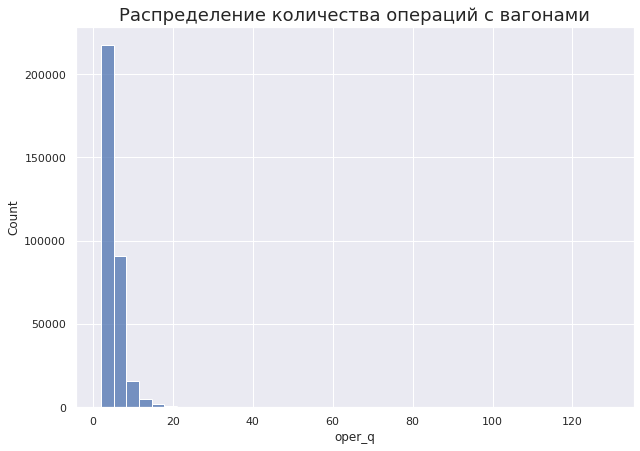

In [38]:
# Распределение кол-ва операций

plt.rcParams['figure.figsize'] = (10, 7) # размер фигуры
sns.set_theme() # стандартный вид графика

fig = sns.histplot(data=data_check, x='oper_q', bins=40) # гистограмма
fig.set_title('Распределение количества операций с вагонами', fontdict={'fontsize': 18})

Text(0.5, 1.0, 'Распределение длительности технологических циклов')

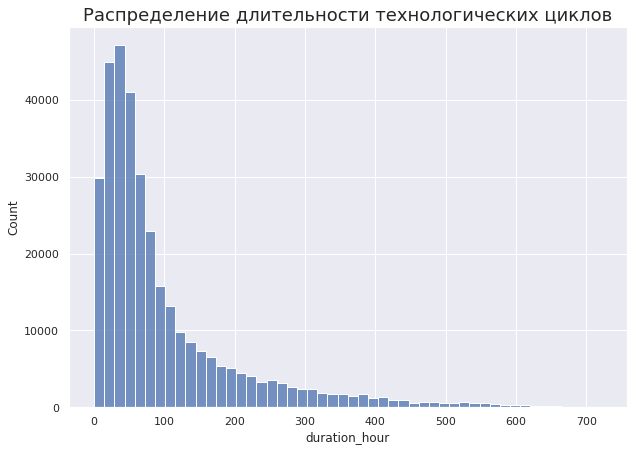

In [39]:
# Распределение длительности технологических циклов

fig = sns.histplot(data=data_check, x='duration_hour', bins=50) # гистограмма
fig.set_title('Распределение длительности технологических циклов', fontdict={'fontsize': 18})

In [40]:
# Найдём модальное значение длины технологического цикла в часах

data_check['duration_hour'].mode()[0]



44.93333333333334

Наиболее часто встречается ситуация, когда технологический цикл укладывается в 45 часов

In [41]:
# Разобъем dataset на два по длительности цикла - до 36 и более 36часов
data_check_smoll = data_check[data_check['duration_hour']<=36]
data_check_big = data_check[data_check['duration_hour']>36]

In [42]:
# Род вагона
data_check['rodvag'].value_counts()

60.0    215134
70.0     39680
96.0     31162
90.0     17109
40.0     14902
20.0     10253
93.0      2053
95.0      1959
87.0       899
92.0       517
99.0         5
Name: rodvag, dtype: int64

In [43]:
data_check_smoll['rodvag'].value_counts()

60.0    72697
96.0     8474
70.0     7701
90.0     4700
40.0     4666
20.0      532
95.0      101
93.0       53
87.0       28
92.0       13
Name: rodvag, dtype: int64

In [44]:
data_check_big['rodvag'].value_counts()# распределение рода вагонов примерно одинаковое в двух выборках

60.0    142437
70.0     31979
96.0     22688
90.0     12409
40.0     10236
20.0      9721
93.0      2000
95.0      1858
87.0       871
92.0       504
99.0         5
Name: rodvag, dtype: int64

Text(0.5, 1.0, 'Род вагона - циклы свыше 36 часов')

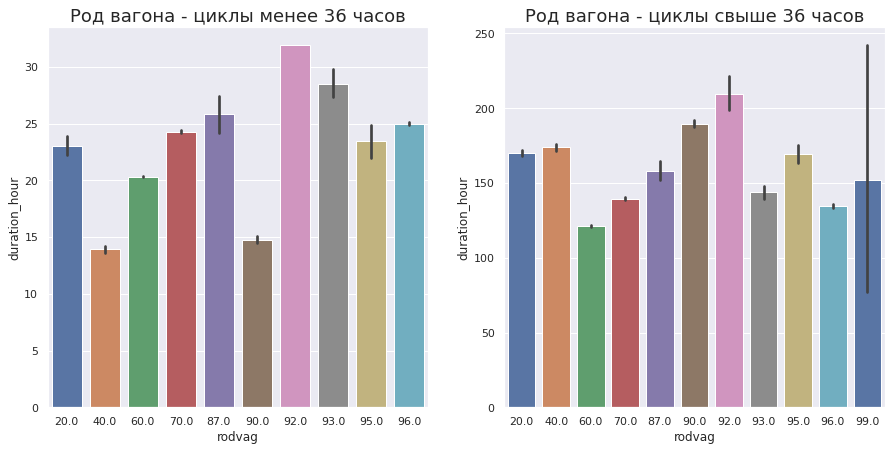

In [45]:
# График - род вагона для циклов более и менее 36 часов

fig1, (ax1) = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(data=data_check_smoll, x='rodvag', y='duration_hour', ax=ax1[0], palette="deep")
ax1[0].set_title('Род вагона - циклы менее 36 часов', fontdict={'fontsize': 18})

sns.barplot(data=data_check_big, x='rodvag', y='duration_hour', ax=ax1[1], palette="deep")
ax1[1].set_title('Род вагона - циклы свыше 36 часов', fontdict={'fontsize': 18})

Возможно речь про то, что в зависимости от рода/типа вагона - его стараются быстрее включить в поезд. В половине случаев успевают за 36 часов. Если станция разгрузки является конечной, то длительность цикла до следующего включения в поезд выше 36 часов.

In [46]:
data_check.to_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/df_includes_check_poezd.csv')

Построение Модели

In [4]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Hakaton/df_includes_check_poezd.csv')
data

,Unnamed: 0,Unnamed: 0.1,operation_st_esr,car_number,operation_car,operation_car_f,operation_l,operation_date,operation_train,oper_all,...,time_oper_f,time_oper_l,time_diff,stnazn,danger,gruz,rodvag,tare_weight,duration,duration_hour
0,3,3,830003.0,24579856,3.0,3.0,4.0,2020-07-26 18:38:00,4.0,"[3.0, 80.0, 19.0, 81.0, 81.0, 4.0, 3.0, 18.0, ...",...,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003.0,0.0,0.0,20.0,NaN,2 days 11:24:00,59.400000
1,4,4,830003.0,24622276,3.0,3.0,4.0,2020-07-15 23:32:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",...,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003.0,0.0,0.0,20.0,NaN,1 days 04:55:00,28.916667
2,5,5,830003.0,28034288,3.0,3.0,4.0,2020-07-25 00:21:00,4.0,"[3.0, 80.0, 28.0, 19.0, 81.0, 81.0, 4.0]",...,2020-07-25 00:21:00,2020-07-28 05:40:00,3 days 05:19:00,830003.0,0.0,0.0,20.0,NaN,3 days 05:19:00,77.316667
3,7,7,830003.0,28035723,3.0,3.0,4.0,2020-07-23 16:57:00,4.0,"[3.0, 81.0, 4.0, 4.0, 4.0]",...,2020-07-23 16:57:00,2020-07-25 08:47:00,1 days 15:50:00,830003.0,0.0,0.0,20.0,NaN,1 days 15:50:00,39.833333
4,14,14,830003.0,29019288,3.0,3.0,4.0,2020-07-24 20:51:00,44.0,"[3.0, 3.0, 3.0, 3.0, 18.0, 4.0, 4.0]",...,2020-07-24 20:51:00,2020-07-28 02:00:00,3 days 05:09:00,830003.0,0.0,0.0,20.0,NaN,3 days 05:09:00,77.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333668,980483,980483,998100.0,61320917,3.0,3.0,4.0,2020-07-07 15:07:00,4.0,"[3.0, 78.0, 20.0, 18.0, 79.0, 4.0]",...,2020-07-07 15:07:00,2020-07-12 01:30:00,4 days 10:23:00,998100.0,0.0,0.0,60.0,NaN,4 days 10:23:00,106.383333
333669,980485,980485,998100.0,62175377,3.0,3.0,4.0,2020-07-25 05:24:00,4.0,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",...,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100.0,0.0,0.0,60.0,NaN,4 days 09:36:00,105.600000
333670,980487,980487,998100.0,63750566,3.0,3.0,4.0,2020-07-25 05:24:00,4.0,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",...,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100.0,0.0,0.0,60.0,NaN,4 days 09:36:00,105.600000
333671,980490,980490,998100.0,66288432,3.0,3.0,4.0,2020-07-25 05:24:00,4.0,"[3.0, 80.0, 21.0, 19.0, 81.0, 4.0]",...,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100.0,0.0,0.0,60.0,NaN,4 days 09:36:00,105.600000


In [5]:
data['st_vag'] = data.apply(lambda row: (row.operation_st_esr, row.car_number), axis=1)
data['attach_36hours'] = data['duration_hour'].apply(lambda x: 1 if x <= 36 else 0)
#Количество операций
data['oper_q'].max()

129

In [6]:
# Сформируем из ДатаСета выборку признаков
data_tr = data[['st_vag', 'oper_q', 'attach_36hours']].copy()
data_tr

,st_vag,oper_q,attach_36hours
0,"(830003.0, 24579856)",9,0
1,"(830003.0, 24622276)",7,1
2,"(830003.0, 28034288)",7,0
3,"(830003.0, 28035723)",5,0
4,"(830003.0, 29019288)",7,0
...,...,...,...
333668,"(998100.0, 61320917)",6,0
333669,"(998100.0, 62175377)",6,0
333670,"(998100.0, 63750566)",6,0
333671,"(998100.0, 66288432)",6,0


In [7]:
# Импорт библиотек для обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score

In [8]:
def metrics(y_test, y_pred):
   
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred).round(5)
    recall = recall_score(y_test, y_pred).round(5)
    roc_auc = roc_auc_score(y_test, y_pred).round(5)
    f1 = f1_score(y_test, y_pred).round(5)
    accuracy = accuracy_score(y_test, y_pred)
    
  
    print('Матрица:')
    print(conf_matrix)
    print('точность (precision) - ', precision)
    print('полнота (recall) -', recall)
    print('roc_auc - ', roc_auc)
    print('f1_score - ', f1)
    print('accuracy - ', accuracy)


In [9]:
RANDOM_STATE = 36

In [17]:
X = data_tr.drop(['st_vag', 'attach_36hours'], axis=1)
Y = data_tr['attach_36hours']


In [18]:
# Разобъем нашу выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True, stratify=Y)

In [19]:
# Разделим X_train на тестовую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train, test_size=0.3, random_state=RANDOM_STATE, shuffle=True, stratify=Y_train)

In [20]:
#RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)
RFC = RFC.fit(X_train, Y_train)
Y_pred = RFC.predict(X_test)
metrics(Y_test, Y_pred)




Матрица:
[[70412     0]
 [29690     0]]
точность (precision) -  0.0
полнота (recall) - 0.0
roc_auc -  0.5
f1_score -  0.0
accuracy -  0.7034025294199916


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
#RFC.n_features_in

In [ ]:
# Подбор гиперпараметров
n_estimators = [10, 25, 40, 60,75]
max_features = [4,6,8,10]
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_valid, Y_valid)
RFC = gs.best_estimator_
gs.best_params_

In [13]:
RFC_bp = RandomForestClassifier(n_estimators=50, 
                                    bootstrap=False,
                                    max_depth=15,
                                    max_features='sqrt',
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    random_state=RANDOM_STATE)
RFC_bp = RFC_bp.fit(X_train, Y_train)
Y_pred = RFC_bp.predict(X_test)
metrics(Y_test, Y_pred)

Матрица:
[[70412     0]
 [29690     0]]
точность (precision) -  0.0
полнота (recall) - 0.0
roc_auc -  0.5
f1_score -  0.0
accuracy -  0.7034025294199916


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
#RFC_bp.n_features_in